In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# df = pd.read_csv('airline-passengers.csv')
df = yf.download('ETH-USD')

In [ ]:
timeseries = df[["Open", "Close", "High", "Low"]].values.astype('float32')
# Normalize the data
scaler = MinMaxScaler()
timeseries = scaler.fit_transform(timeseries)
# Then, later, once we have predicted data, we can call scaler.inverse_transform(predicted_data)

In [ ]:
# Choose how much past data a prediction is based on
seq_length = 10 # days
train_test_split_percentage = 0.67
batch_size = 32 # not optimized yet
feature_amount = 4 # For Open/Close/High/Low

# Define a function to create in/out sequence data
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-1):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq , train_label))
    return inout_seq

inout_seq = create_inout_sequences(timeseries, seq_length)

# Split data into train and test sets
train_size = int(len(inout_seq) * train_test_split_percentage)
train_set = inout_seq[:train_size]
test_set = inout_seq[train_size:]

# Convert inout_seq to tensors inside the list comprehension
train_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in train_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in train_set]))
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in test_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in test_set]))
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [ ]:
print(train_data.__len__())
print(train_data[0])
# Shape is 1494,4x10,4x1

In [ ]:
class StockPricePredictorLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=4):
        super(StockPricePredictorLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, self.hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_layer_size, output_size)

        # self.hidden_cell = (torch.zeros(1, batch_size,self.hidden_layer_size),
        #                     torch.zeros(1, batch_size, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        # lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

# Initialize model
model = StockPricePredictorLSTM(input_size=feature_amount,output_size=feature_amount)
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
epochs = 500
for i in range(epochs):
    # Size 32,10,4 and 32,1,4 respectively
    for seq, labels in train_loader:
        seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()

        model.train()
        optimizer.zero_grad()
        # Reset the hidden state. Avoid using states across batches.
        # model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda(),
                            #  torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda())

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if i%25 == 0:
        with torch.no_grad():
            model.eval()
            test_losses = []
            test_predictions = []

            # Iterate over test data
            for seq, labels in test_loader:
                seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()
                y_pred = model(seq)
                test_predictions.append(test_predictions)
                test_loss = loss_function(y_pred, labels)
                test_losses.append(test_loss.item())
            # Report the average test loss
            avg_test_loss = np.mean(test_losses)
        print(f'epoch: {i:3} train loss: {loss.item():10.8f}, test loss: {avg_test_loss:10.8f}')

print(f'epoch: {i:3} train loss: {loss.item():10.8f} test loss: {avg_test_loss:10.8f}')

epoch:   0 train loss: 0.05683294, test loss: 0.09691589
epoch:  25 train loss: 0.00049093, test loss: 0.00162067
epoch:  50 train loss: 0.00039573, test loss: 0.00076366
epoch:  75 train loss: 0.00048646, test loss: 0.00057566
epoch: 100 train loss: 0.00019090, test loss: 0.00063202
epoch: 125 train loss: 0.00048679, test loss: 0.00049473
epoch: 150 train loss: 0.00026878, test loss: 0.00037198
epoch: 175 train loss: 0.00023321, test loss: 0.00034881
epoch: 200 train loss: 0.00113702, test loss: 0.00027222
epoch: 225 train loss: 0.00015837, test loss: 0.00030686
epoch: 250 train loss: 0.00010867, test loss: 0.00028829
epoch: 275 train loss: 0.00012131, test loss: 0.00025624
epoch: 300 train loss: 0.00010572, test loss: 0.00023237
epoch: 325 train loss: 0.00015789, test loss: 0.00018169
epoch: 350 train loss: 0.00007841, test loss: 0.00016963
epoch: 375 train loss: 0.00005070, test loss: 0.00017481
epoch: 400 train loss: 0.00004969, test loss: 0.00017452
epoch: 425 train loss: 0.000069

In [ ]:
def predict_n_days_ahead(n):
    # Move the model to evaluation mode
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        test_predictions = []
        # To predict n days in advance, we'll iterate and feed predictions back as input n times
        for seq, _ in test_loader:
            seq = seq.cuda() # shape [batch_size,seq_length,feature_amount]
            for i in range(n):
              preds = model(seq) # shape [batch_size, feature_amount]
              preds = preds.unsqueeze(1) # shape [batch_size, 1, feature_amount]
              # Now we can use add the prediction to the sequence
              seq = torch.cat((seq, preds), dim=1) # shape [batch_size, seq_length + 1, feature_amount]
              # and drop the oldest sequence entry
              seq = seq[:, 1:, :] # shape [batch_size, seq_length, feature_amount]
            for p in preds.squeeze(1).cpu().numpy():
              test_predictions.append(p[1])  # Only taking the close value of the last prediction
        return np.array(test_predictions)

In [ ]:
# Example test item and model prediction for it
print(seq[0])
print(model(seq)[0])

tensor([[0.0601, 0.0614, 0.0606, 0.0588],
        [0.0614, 0.0641, 0.0629, 0.0615],
        [0.0642, 0.0595, 0.0632, 0.0586],
        [0.0595, 0.0620, 0.0622, 0.0593],
        [0.0620, 0.0593, 0.0616, 0.0606],
        [0.0593, 0.0595, 0.0598, 0.0591],
        [0.0596, 0.0645, 0.0642, 0.0608],
        [0.0646, 0.0635, 0.0638, 0.0635],
        [0.0634, 0.0637, 0.0628, 0.0638],
        [0.0638, 0.0607, 0.0625, 0.0613]], device='cuda:0')
tensor([0.0629, 0.0641, 0.0659, 0.0617], device='cuda:0',
       grad_fn=<SelectBackward0>)


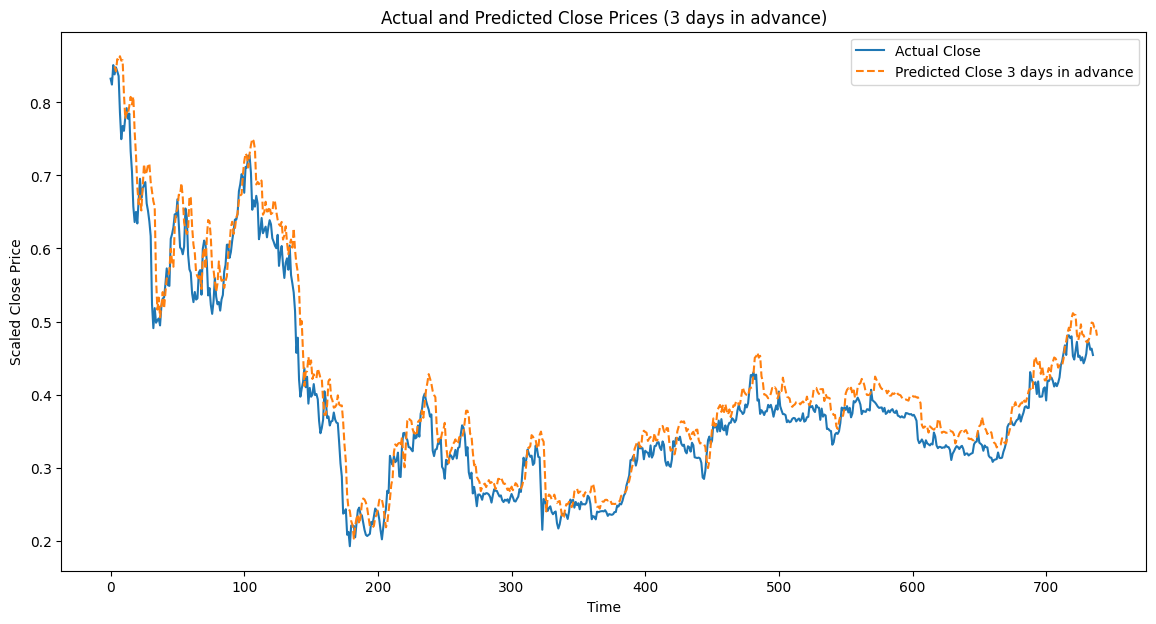

In [ ]:
n_ahead = 3
empty_items = np.empty((n_ahead)) * np.nan

# Note that this starts at day 10 of the test set, because of the chunking
original_data = torch.stack([torch.FloatTensor(s[0]) for s in test_set])
# original_close_data = original_data[:, -1, 1].numpy()
original_close_data = np.concatenate((original_data[:, -1, 1].numpy(), empty_items))

# Starts at prediction for day 13, because we predict 3 days ahead, so we pad the start
predicted_close_3_days = np.concatenate((empty_items, predict_n_days_ahead(n_ahead)))
# predicted_close_3_days = predict_n_days_ahead(n_ahead)

plt.figure(figsize=(14,7))
plt.title('Actual and Predicted Close Prices (3 days in advance)')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.plot(original_close_data, label='Actual Close')
plt.plot(predicted_close_3_days, label='Predicted Close 3 days in advance', linestyle='--')
plt.legend()
plt.show()